# Import modules

In [1]:
import os
import numpy as np
import torch
import os
import re
import json
import argparse
import pandas as pd
import random
from transformers import T5Tokenizer, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, T5ForConditionalGeneration
from rich.table import Column, Table
from rich import box
from rich.console import Console
console = Console(record=True)
from torch import cuda
import nltk
import evaluate
import imgkit
from html2image import Html2Image
import pdfkit
from pdf2image import convert_from_path
import glob, sys, fitz
from PIL import Image, ImageDraw, ImageOps
from torch.utils.data import Dataset, DataLoader
from collections import namedtuple

from PIL import Image
import requests
from transformers import AutoProcessor, Pix2StructForConditionalGeneration
import pickle

import matplotlib.pyplot as plt
from rouge import Rouge

/Users/rohanwadhawan/Desktop/UCLA/research/peng-lab/project/mm-cot/mmcot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data visualization

In [2]:
def read_captions():
    captions_dict = dict(pd.read_json(os.path.join(os.getcwd(), "data", "captions.json"))["captions"])
    return captions_dict

In [3]:
captions_dict = read_captions()

In [4]:
def read_problem_list(captions_dict = None):
    
    problem_list = pd.read_json(os.path.join(os.getcwd(), "data", "scienceqa", "problems.json"))
    return problem_list

In [5]:
problem_list = read_problem_list(captions_dict)

In [6]:
problem_list.keys()

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            21199, 21200, 21201, 21202, 21203, 21204, 21205, 21206, 21207,
            21208],
           dtype='int64', length=21208)

In [7]:
print(problem_list[1]["image"])

image.png


In [8]:
print(problem_list[1]["split"])

train


In [9]:
print(problem_list[1]["task"])

closed choice


In [10]:
print(problem_list[2]["hint"])

The passage below describes an experiment. Read the passage and then follow the instructions below.

Tom placed a ping pong ball in a catapult, pulled the catapult's arm back to a 45° angle, and launched the ball. Then, Tom launched another ping pong ball, this time pulling the catapult's arm back to a 30° angle. With each launch, his friend Justin measured the distance between the catapult and the place where the ball hit the ground. Tom and Justin repeated the launches with ping pong balls in four more identical catapults. They compared the distances the balls traveled when launched from a 45° angle to the distances the balls traveled when launched from a 30° angle.
Figure: a catapult for launching ping pong balls.


In [11]:
len(problem_list.keys())

21208

In [12]:
choice_len = []
for i in range(len(problem_list.keys())):
    choice_len.append(len(problem_list[i+1]["choices"]))
print(np.unique(choice_len))
#     print(problem_list[i+1]["choices"])

[2 3 4 5]


In [13]:
print(problem_list[1]["answer"])

0


In [14]:
print(problem_list[1]["solution"])

To find the answer, look at the compass rose. Look at which way the north arrow is pointing. West Virginia is farthest north.


In [15]:
print(len((problem_list[1]["lecture"]).split(" ")))

60


In [16]:
def get_datastats(df,  idx_list = None):
    question_len = {
        "min":10000,
        "max":0,
        "avg":0.0
    }
    lecture_len = {
        "min":10000,
        "max":0,
        "avg":0.0
    }
    solution_len = {
        "min":10000,
        "max":0,
        "avg":0.0
    }
    img_cnt = 0
    
    if idx_list is None:
        iterate_list = df.keys().values
    else:
        iterate_list = idx_list
    
    for i in iterate_list:
        qlen = len(df[i]["question"].split(" "))
        llen = len(df[i]["lecture"].split(" "))
        slen = len(df[i]["solution"].split(" "))

        #check min, max and avg length of question
        if qlen < question_len["min"]:
            question_len["min"] = qlen
        if qlen > question_len["max"]:
            question_len["max"] = qlen
        question_len["avg"]+= qlen

        #check min, max and avg length of lecture
        if llen < lecture_len["min"]:
            lecture_len["min"] = llen
        if llen > lecture_len["max"]:
            lecture_len["max"] = llen
        lecture_len["avg"]+= llen

        #check min, max and avg length of rationale / solution
        if slen < solution_len["min"]:
            solution_len["min"] = slen
        if slen > solution_len["max"]:
            solution_len["max"] = slen
        solution_len["avg"]+= slen

        #check # questions with images
        if df[i]["image"] is not None:
            img_cnt+=1

    question_len["avg"]/= len(df.keys().values)
    lecture_len["avg"]/= len(df.keys().values)
    solution_len["avg"]/= len(df.keys().values)

    # printing stats
    print(f"Question min len {question_len['min']} - max len {question_len['max']} - avg len {question_len['avg']}")
    print(f"Lecture min len {lecture_len['min']} - max len {lecture_len['max']} - avg len {lecture_len['avg']}")
    print(f"Solution min len {solution_len['min']} - max len {solution_len['max']} - avg len {solution_len['avg']}")
    print(f"Samples with images {img_cnt} out of a total of {len(iterate_list)}")
    


In [17]:
get_datastats(problem_list)

Question min len 3 - max len 140 - avg len 11.8439268200679
Lecture min len 1 - max len 469 - avg len 101.15668615616748
Solution min len 1 - max len 429 - avg len 41.78135609204074
Samples with images 10332 out of a total of 21208


# Get specific data split data frames

In [18]:
def read_pid_splits():
    with open(os.path.join(os.getcwd(), "data", "scienceqa", "pid_splits.json")) as json_file:
        data = json.load(json_file)
    return data

In [19]:
pid_splits = read_pid_splits()

In [20]:
print(pid_splits.keys())

dict_keys(['train', 'val', 'test', 'trainval', 'minitrain', 'minival', 'minitest'])


In [21]:
def get_specific_split(pid_splits, split_name="train"):
    return [int(i) for i in pid_splits[split_name]]

In [22]:
train_split = get_specific_split(pid_splits, split_name = "train")

In [23]:
get_datastats(problem_list, train_split)

Question min len 3 - max len 140 - avg len 7.16375895888344
Lecture min len 1 - max len 469 - avg len 60.77404752923425
Solution min len 1 - max len 429 - avg len 25.29644473783478
Samples with images 6218 out of a total of 12726


In [24]:
def get_datastats_all_split(problem_list, pid_splits):
    for split in pid_splits.keys():
        print(f"----- Printing stats for split {split} -----")
        get_datastats(problem_list, get_specific_split(pid_splits, split_name = split))
        print(f"\n-----  -----\n")

In [25]:
get_datastats_all_split(problem_list, pid_splits)

----- Printing stats for split train -----
Question min len 3 - max len 140 - avg len 7.16375895888344
Lecture min len 1 - max len 469 - avg len 60.77404752923425
Solution min len 1 - max len 429 - avg len 25.29644473783478
Samples with images 6218 out of a total of 12726

-----  -----

----- Printing stats for split val -----
Question min len 3 - max len 134 - avg len 2.2984251225952472
Lecture min len 1 - max len 469 - avg len 20.132497170878914
Solution min len 1 - max len 369 - avg len 8.268153526970954
Samples with images 2097 out of a total of 4241

-----  -----

----- Printing stats for split test -----
Question min len 3 - max len 120 - avg len 2.3817427385892116
Lecture min len 1 - max len 469 - avg len 20.25014145605432
Solution min len 1 - max len 337 - avg len 8.216757827235005
Samples with images 2017 out of a total of 4241

-----  -----

----- Printing stats for split trainval -----
Question min len 3 - max len 140 - avg len 9.462184081478688
Lecture min len 1 - max len 4

# Prepare HTML - JPEG content

In [26]:
def create_question_tag():
    question_tag = "<h2>{question_content}</h2>"
    return question_tag

In [27]:
def create_choice_tag():
    choice_tag = "<h3>{choice_content}</h3>"
    return choice_tag

In [28]:
def create_img_tag():
    img_tag = '<img src="{img_source}">'
    return img_tag

In [29]:
def create_context_tag():
    context_tag = "<p>{context_content}</p>"
    return context_tag

In [30]:
def create_lecture_tag():
    lecture_tag = "<p>{lecture_content}</p>"
    return lecture_tag

In [31]:
def create_html_template_modular():
    html_template = \
        '''
            <html>
                <body style="background-color:white;">
                    {question_tag}
                    {choice_tag}
                    {img_tag}
                    {context_tag}
                    {lecture_tag}
                </body>
            </html>
        '''
    return html_template

In [32]:
options = ["A", "B", "C", "D", "E"]

In [33]:
def get_choice_text(problem, options, verbose = False):
    choices = problem['choices']
    choice_list = []
    for i, c in enumerate(choices):
        choice_list.append("({}) {}".format(options[i], c))
    choice_txt = " ".join(choice_list)
    if verbose:
        print(choice_txt)
    
    return choice_txt

In [34]:
choice_txt = get_choice_text(problem_list[1], options)

In [39]:
def create_html_file_modular(params, df, sample_num=None):

    # create individual tags
    
    # Question
    if params["set_question_as_header"] == False:
        question_tag = create_question_tag().format(question_content = df[sample_num]["question"])
        
    else:
        question_tag = ""
        
    # Choices
    if params["set_question_as_header"] == False:
        choice_tag = create_choice_tag().format(choice_content = get_choice_text(df[sample_num], options))
        
    else:
        choice_tag = ""
        
    # Image source
    if df[sample_num]["image"] is not None:
        img_tag = create_img_tag().format(img_source = os.path.join(os.getcwd(), "data", df[sample_num]["split"], \
                              str(sample_num), df[sample_num]['image']))
    else:
        img_tag = ""

    # Context
    if df[sample_num]["hint"] is not None and params["skip_text_context"] == False:
        context_tag = create_context_tag().format(context_content = df[sample_num]["hint"])    
    else:
        context_tag = ""


    # Lecture
    if df[sample_num]["lecture"] is not None and params["skip_lecture"] == False:
        lecture_tag = create_lecture_tag().format(lecture_content = df[sample_num]['lecture']) 

    else:
        lecture_tag = ""
    
    # compose tags to html
    final_html_file = create_html_template_modular().format(question_tag = question_tag, choice_tag = choice_tag, \
                                          img_tag = img_tag, context_tag = context_tag, \
                                          lecture_tag = lecture_tag)
    
    return final_html_file


In [49]:
params = {
    "set_question_as_header": False,
    "skip_text_context":True,
    "skip_lecture":True
}

In [50]:
test_html_file = create_html_file_modular(params, problem_list, sample_num=1)

In [51]:
print(test_html_file)


            <html>
                <body style="background-color:white;">
                    <h2>Which of these states is farthest north?</h2>
                    <h3>(A) West Virginia (B) Louisiana (C) Arizona (D) Oklahoma</h3>
                    <img src="/Users/rohanwadhawan/Desktop/UCLA/research/peng-lab/document-vqa/data/train/1/image.png">
                    
                    
                </body>
            </html>
        


In [46]:
def create_html_template(choice = None):
    if choice is not None:
        html_template = \
        '''
            <html>
                <img src="{img_source}">
                <p>
                    {context}
                </p>
                <p>
                    {lecture}
                </p>
            </html>
        '''
    else:
        html_template = \
        '''
            <html>
                <p>
                    {context}
                </p>
                <p>
                    {lecture}
                </p>
            </html>
        '''
    return html_template

In [47]:
html_template = create_html_template(choice="img")
print(html_template)


            <html>
                <img src="{img_source}">
                <p>
                    {context}
                </p>
                <p>
                    {lecture}
                </p>
            </html>
        


In [48]:
def create_html_file(html_template, df, sample_num=None):

    # Image source
    img_source = os.path.join(os.getcwd(), "data", df[sample_num]["split"], \
                              str(sample_num), df[sample_num]['image']) \
                            if df[sample_num]["image"] is not None else ""

    # Context
    context = df[sample_num]["hint"] if df[sample_num]["hint"] is not None else ""

    # Lecture
    lecture = df[sample_num]["lecture"] if df[sample_num]["lecture"] is not None else ""

    final_html_file = html_template.format(img_source = img_source, context = context, lecture = lecture)
    return final_html_file


In [52]:
final_html_file = create_html_file(test_html_template, problem_list, sample_num=1)
print(final_html_file)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 final_html_file = create_html_file(test_html_template, problem_list, sample_num=1)           │
│   2 print(final_html_file)                                                                       │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'test_html_template' is not defined

In [53]:
def save_html_file(html_file, source, img_num, save_dir=""):
    with open(os.path.join(save_dir, f"{source}_{img_num}.html"), "w") as f:
        f.writelines(html_file)

In [54]:
save_html_file(test_html_file, source = problem_list[1]["split"], img_num=1, \
               save_dir=os.path.join(os.getcwd(), "data", "html_files"))

## Convert to PDF using wkhtmltopdf and pdfkit

In [55]:
test_html_filename = os.path.join(os.getcwd(), "data", "html_files",f"{problem_list[1]['split']}_{1}")
test_pdf_filename = os.path.join(os.getcwd(), "data", "html_files",f"{problem_list[1]['split']}_{1}")

In [56]:
def convert_html_to_pdf(path_to_inputfile, path_to_outputfile):
    pdfkit.from_file(f'{path_to_inputfile}.html', f'{path_to_outputfile}.pdf')

In [57]:
convert_html_to_pdf(test_html_filename, test_pdf_filename)

## Convert PDF to image 

In [58]:
test_pdf_filename = os.path.join(os.getcwd(), "data", "html_files",f"{problem_list[1]['split']}_{1}")
test_image_filename = os.path.join(os.getcwd(), "data", "html_files",f"{problem_list[1]['split']}_{1}")

In [59]:
def convert_pdf_to_image(path_to_inputfile, path_to_outputfile):
    
    # To get better resolution
    zoom_x = 1.0  # horizontal zoom
    zoom_y = 1.0  # vertical zoom
    mat = fitz.Matrix(zoom_x, zoom_y)  # zoom factor 2 in each dimension

    filename = f"{path_to_inputfile}.pdf"
    doc = fitz.open(filename)  # open document
    for page in doc:  # iterate through the pages
        pix = page.get_pixmap(matrix=mat)  # render page to an image
        pix.save(f"{path_to_outputfile}.jpg")  # store image as JPG

In [60]:
convert_pdf_to_image(test_pdf_filename, test_image_filename)

## Crop whitespace from image

In [61]:
def remove_white_space(filename, padding = 30, visualize = False):
    
    # Open input image
    im = Image.open(filename)
    
    # Get bounding box of text and trim to it
    bbox = ImageOps.invert(im).getbbox()
    x, y = 0, 0
    x_, y_ = im.size[0], bbox[3] + padding
    new_bbox = (x, y, x_, y_)
    trimmed = im.crop(new_bbox)
    trimmed.save(filename)
    if visualize:
        trimmed.show()

In [62]:
remove_white_space(f"{test_image_filename}.jpg")

In [63]:
# # find padding value
# # Open input image
# im = Image.open(f"{test_image_filename}.png")
# print(im.size)
# print(f"{test_image_filename}.png")
# # Get bounding box of text and trim to it
# bbox = ImageOps.invert(im).getbbox()
# # trimmed = im.crop(bbox)
# print(type(bbox))

## Convert Input to Image

In [64]:
# os.path.exists("/Users/rohanwadhawan/Desktop/UCLA/research/peng-lab/document-vqa/data/new_input")

In [65]:
def convert_input_to_img(problem_list, pid_splits, source="train", html_template_choice=None, save_dir="", \
                         sample_subset = 10, crop_padding = 30, remove_html_file = True, remove_pdf_file = True, \
                         params=None):
    
    idx_list = pid_splits[source] 
    idx_list = [int(idx) for idx in idx_list]
    
    if sample_subset is not None:
        idx_list = idx_list[:sample_subset]
        source = "tiny_" + source
    
    # create save directory if it does not exist
    save_dir = os.path.join(save_dir, source)
        
    if os.path.exists(save_dir) == False:
        os.makedirs(save_dir)
        print("Save directory created")
    else:
        print("Save directory already present")
        
    
    for sample_num in idx_list:
        
        # create html template
#         html_template = create_html_template(html_template_choice)
        html_template = create_html_file_modular(params, problem_list, sample_num=sample_num)
        html_file = create_html_file(html_template, problem_list, sample_num)
        
        # save tmp html file
        save_html_file(html_file, source, sample_num, save_dir=save_dir)
        
        # tmp and final filenames
        tmp_hpi_filename = os.path.join(os.getcwd(), save_dir, f"{source}_{sample_num}")
        img_filename = os.path.join(os.getcwd(), save_dir, f"{source}_{sample_num}")
        
        # convert tmp html to tmp pdf & delete tmp html file
        convert_html_to_pdf(tmp_hpi_filename, tmp_hpi_filename)
        
        # convert tmp pdf to image & delete tmp pdf file
        convert_pdf_to_image(tmp_hpi_filename, img_filename)
        
        # crop whitespace
        remove_white_space(f"{img_filename}.jpg")
        
        # cleaning by removing tmp files
        if remove_html_file:
            os.remove(f"{tmp_hpi_filename}.html")
        
        if remove_pdf_file:
            os.remove(f"{tmp_hpi_filename}.pdf")

In [56]:
params = {
    "set_question_as_header": False
}

In [71]:
# convert_input_to_img(problem_list, pid_splits, source="train", html_template_choice = "img", 
#                      save_dir=os.path.join(os.getcwd(), "data", "new_data"), sample_subset = 10, 
#                      crop_padding = 30, params = params)

In [72]:
convert_input_to_img(problem_list, pid_splits, source="train", html_template_choice = "img", 
                     save_dir=os.path.join(os.getcwd(), "data", "new_data", "unimodal"), sample_subset = 20 , 
                     crop_padding = 30, params = params)

Save directory created


In [73]:
convert_input_to_img(problem_list, pid_splits, source="val", html_template_choice = "img", 
                     save_dir=os.path.join(os.getcwd(), "data", "new_data", "unimodal"), sample_subset = 4, 
                     crop_padding = 30, params = params)

Save directory created


In [74]:
convert_input_to_img(problem_list, pid_splits, source="test", html_template_choice = "img", 
                     save_dir=os.path.join(os.getcwd(), "data", "new_data", "unimodal"), sample_subset = 4, 
                     crop_padding = 30, params = params)

Save directory created


# Create custom loading and training template

## Convert Science to dataset (header_text, image, output) - Dataloader - Collator

In [57]:
options = ["A", "B", "C", "D", "E"]

In [58]:
output_format = "AE"

In [59]:
ScienceQA = namedtuple("ScienceQA", "sample_num header_text image image_mean image_std output")

In [60]:
def preprocess_image_pix2struct(image):
    im_arr = np.array(image)
    im_arr16 = im_arr.astype(np.float16)
    
    im_arr16_mean = np.mean(im_arr16)
    im_arr_16_tstd = np.sqrt(np.mean((im_arr16 - im_arr16_mean)**2))
    N = im_arr16.shape[0]*im_arr16.shape[1]*im_arr16.shape[2]
    im_arr16_std = max(im_arr_16_tstd, 1.0/np.sqrt(N))

    im_arr16_final = (im_arr16 - im_arr16_mean)/im_arr16_std
    
    im_tensor = torch.tensor(im_arr16_final)
#     print(im_tensor.shape)
   
    return im_tensor, im_arr16_mean, im_arr16_std

In [61]:
def visualize_processed_image(image, mean, std):
    image  = np.array(image * std + mean, dtype = np.uint8)
    plt.imshow(image)
    plt.show()

In [65]:
test_image_filename = os.path.join(os.getcwd(), "data","new_data","unimodal","train",f"{problem_list[1]['split']}_{1}")

In [66]:
image = Image.open(f"{test_image_filename}.jpg")

In [67]:
pre_image, pre_mean, pre_std = preprocess_image_pix2struct(image)

In [68]:
# print(pre_image)
# np.unique(pre_image)

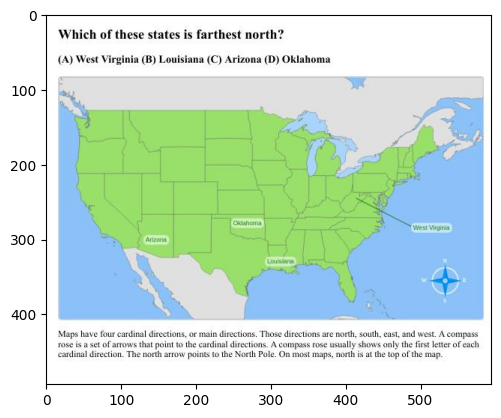

In [69]:
visualize_processed_image(pre_image, pre_mean, pre_std)

In [70]:
def create_one_scienceqa_example(problem_list, img_filename="", sample_num=1, output_format="AE", options = None, preprocess_image=None):
    
    # header text
    header_text = problem_list[sample_num]["question"] + " " + get_choice_text(problem_list[sample_num], options)
    
    #input
    image = Image.open(f"{img_filename}.jpg")
    image_mean = 0
    image_std = 0
    if preprocess_image is not None:
        image, image_mean, image_std = preprocess_image(image)
    
    # Outputs
    if output_format == 'A':
        output = f"Answer: The answer is {problem_list[sample_num]['answer']}."
    elif output_format == 'AE':
        output = f"Answer: The answer is {problem_list[sample_num]['answer']}. BECAUSE: {problem_list[sample_num]['solution']}"
    elif output_format == 'EA':
        output = f"Answer: {problem_list[sample_num]['solution']} The answer is {problem_list[sample_num]['answer']}."

    output = output.replace("  ", " ").strip()
    if output.endswith("BECAUSE:"):
        output = output.replace("BECAUSE:", "").strip()
    
    scienceqa_example = ScienceQA(sample_num, header_text, image, image_mean, image_std, output)
    return scienceqa_example

In [71]:
sample_num = 1
test_image_filename = os.path.join(os.getcwd(), "data", "html_files", f"{problem_list[sample_num]['split']}_{sample_num}")
test_example = create_one_scienceqa_example(problem_list, img_filename=test_image_filename, 
                                  sample_num=sample_num, output_format=output_format, options = options,
                                    preprocess_image = None) #preprocess_image_pix2struct)

In [72]:
print(test_example.header_text)
test_example.image.show()
# print(test_example.processed_image)
print(test_example.output)

Which of these states is farthest north? (A) West Virginia (B) Louisiana (C) Arizona (D) Oklahoma
Answer: The answer is 0. BECAUSE: To find the answer, look at the compass rose. Look at which way the north arrow is pointing. West Virginia is farthest north.


In [73]:
def convert_scienceqa_to_dataset(problem_list, pid_splits, source="train", save_dir = "", output_format="AE", \
                                 options = None, preprocess_image = None, sample_subset = None):
    
    
    idx_list = pid_splits[source] 
    idx_list = [int(idx) for idx in idx_list]
    
    if sample_subset is not None:
        idx_list = idx_list[:sample_subset]
        source = "tiny_"+source
        
    save_dir = os.path.join(save_dir, source)    
    
    dataset = []
    for sample_num in idx_list:
        ifile = os.path.join(os.getcwd(), save_dir, f"{source}_{sample_num}")
        dataset.append(create_one_scienceqa_example(problem_list, img_filename=ifile, \
                                                    sample_num=sample_num, output_format=output_format, \
                                                    options = options, preprocess_image = preprocess_image))
    return dataset
        

In [76]:
source = "train"
sample_subset = None # 20
train_dataset = convert_scienceqa_to_dataset(problem_list, pid_splits, source=source, \
                      save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal"), output_format=output_format, \
                      options = options, preprocess_image = None, sample_subset = sample_subset) #preprocess_image_pix2struct)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 source = "train"                                                                             │
│   2 sample_subset = None # 20                                                                    │
│   3 train_dataset = convert_scienceqa_to_dataset(problem_list, pid_splits, source=source, \      │
│ ❱ 4 │   │   │   │   │     save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal     │
│   5 │   │   │   │   │     options = options, preprocess_image = None, sample_subset = sample     │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
OSError: [Errno 24] Too many open files

In [77]:
source = "val"
sample_subset = None # 4
val_dataset = convert_scienceqa_to_dataset(problem_list, pid_splits, source=source, \
                      save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal"), output_format=output_format, \
                      options = options, preprocess_image = None, sample_subset = sample_subset) #preprocess_image_pix2struct)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 source = "val"                                                                               │
│   2 sample_subset = None # 4                                                                     │
│   3 val_dataset = convert_scienceqa_to_dataset(problem_list, pid_splits, source=source, \        │
│ ❱ 4 │   │   │   │   │     save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal     │
│   5 │   │   │   │   │     options = options, preprocess_image = None, sample_subset = sample     │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
OSError: [Errno 24] Too many open files

In [132]:
source = "test"
sample_subset = None # 4
test_dataset = convert_scienceqa_to_dataset(problem_list, pid_splits, source=source, \
                      save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal"), output_format=output_format, \
                      options = options, preprocess_image = None, sample_subset = sample_subset) #preprocess_image_pix2struct)

Exception in thread Exception in threading.excepthook:
Exception ignored in thread started by: <bound method Thread._bootstrap of <HistorySavingThread(IPythonHistorySavingThread, started 6235123712)>>
Traceback (most recent call last):
  File "/Users/rohanwadhawan/miniconda3/lib/python3.10/threading.py", line 973, in _bootstrap
  File "/Users/rohanwadhawan/miniconda3/lib/python3.10/threading.py", line 1018, in _bootstrap_inner


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.

  File "/Users/rohanwadhawan/miniconda3/lib/python3.10/threading.py", line 1336, in invoke_excepthook
zmq.error.ZMQError: Too many open files
Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "/Users/rohanwadhawan/Desktop/UCLA/research/peng-lab/project/mm-cot/mmcot/lib/python3.10/site-packages/ipykernel/iostream.py", line 492, in flush
  File "/Users/rohanwadhawan/Desktop/UCLA/research/peng-lab/project/mm-cot/mmcot/lib/python3.10/site-packages/ipykernel/iostream.py", line 211, in schedule
  File "/Users/rohanwadhawan/Desktop/UCLA/research/peng-lab/project/mm-cot/mmcot/lib/python3.10/site-packages/ipykernel/iostream.py", line 98, in _event_pipe
  File "/Users/rohanwadhawan/Desktop/UCLA/research/peng-lab/project/mm-cot/mmcot/lib/python3.10/site-packages/zmq/sugar/context.py", line 362, in socket
  File "/Users/rohanwadhawan/Desktop/UCLA/research/peng-lab/project/mm-cot/mmcot/lib/python3.10/site-packages/zmq/sugar/socket.

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 source = "test"                                                                              │
│   2 sample_subset = None # 4                                                                     │
│   3 test_dataset = convert_scienceqa_to_dataset(problem_list, pid_splits, source=source, \       │
│ ❱ 4 │   │   │   │   │     save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal     │
│   5 │   │   │   │   │     options = options, preprocess_image = None, sample_subset = sample     │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
OSError: [Errno 24] Too many open files

In [126]:
# minitrain_dataset

#### Save dataset

In [127]:
def save_dataset(dataset, save_dir="", filename=""):
    pickle_filename = os.path.join(save_dir, filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump(dataset, f)

In [128]:
save_dataset(
    train_dataset,
    save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal"),
    filename = "minitrain.pkl"
)

In [129]:
save_dataset(
    val_dataset,
    save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal"),
    filename = "minival.pkl"
)

In [130]:
save_dataset(
    test_dataset,
    save_dir = os.path.join(os.getcwd(), "data", "new_data", "unimodal"),
    filename = "minitest.pkl"
)

##### Load Test

In [78]:
# pickle_filename = os.path.join(os.getcwd(), "data", "new_data", "minitrain.pkl")
# with open(pickle_filename, 'rb') as f:
#     minitrain_dataset = pickle.load(f)

In [79]:
# pickle_filename = os.path.join(os.getcwd(), "data", "new_data", "minival.pkl")
# with open(pickle_filename, 'rb') as f:
#     minival_dataset = pickle.load(f)

In [80]:
# pickle_filename = os.path.join(os.getcwd(), "data", "new_data", "minitest.pkl")
# with open(pickle_filename, 'rb') as f:
#     minitest_dataset = pickle.load(f)

In [81]:
# temp_minitrain[0]

### Dataloader

In [264]:
MAX_PATCHES = 1024 # make it 2048 for base and 4096 for large

class VQADataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __gettext__(self, idx):
        return len(self.dataset[idx].output.split(" "))
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item.image, return_tensors="pt", add_special_tokens=True, max_patches=MAX_PATCHES)
        
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = item.output
        encoding["sample_num"] = item.sample_num
        return encoding

### Load model and processor

In [265]:
processor = AutoProcessor.from_pretrained("google/pix2struct-base")
model = Pix2StructForConditionalGeneration.from_pretrained("google/pix2struct-base")
# model.half()

In [266]:
a = torch.tensor([1.0, 2.0])

In [267]:
print(a)
print(type(a))
print(a.dtype)
a = a.half()
print(a.dtype)

tensor([1., 2.])
<class 'torch.Tensor'>
torch.float32
torch.float16


In [268]:
# processor.image_processor.do_convert_rgb = False
# processor.image_processor.do_normalize = False
processor.image_processor.convert_fp16 = False

### Data Collator



In [455]:
def collator(batch):
    new_batch = {"flattened_patches":[], "attention_mask":[]}
    texts = [item["text"] for item in batch]

    text_inputs = processor(text=texts, padding="max_length", return_tensors="pt", add_special_tokens=True, max_length=512)
    new_batch["labels"] = text_inputs.input_ids

    for item in batch:
        new_batch["flattened_patches"].append(item["flattened_patches"])
        new_batch["attention_mask"].append(item["attention_mask"])

    new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
    new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])
    new_batch["sample_num"] = [item["sample_num"] for item in batch]

    return new_batch

### Create the necessary variable

In [456]:
minitrain_vqadataset = VQADataset(minitrain_dataset, processor)
minitrain_dataloader = DataLoader(minitrain_vqadataset, shuffle=True, batch_size=1, collate_fn=collator)

In [457]:
data_sample = next(iter(minitrain_dataloader))

In [458]:
data_sample["labels"][0].shape

torch.Size([512])

In [459]:
minival_vqadataset = VQADataset(minival_dataset, processor)
minival_dataloader = DataLoader(minival_vqadataset, shuffle=True, batch_size=2, collate_fn=collator)

In [460]:
minitest_vqadataset = VQADataset(minitest_dataset, processor)
minitest_dataloader = DataLoader(minitest_vqadataset, shuffle=True, batch_size=2, collate_fn=collator)

## Evaluate Model

In [461]:
def extract_explanation(text):
    text = re.sub(r"The answer is [A-Z]. BECAUSE: ", "", text)
    return text


In [462]:
def score_rouge(str1, str2):
    rouge = Rouge(metrics=["rouge-l"])
    scores = rouge.get_scores(str1, str2, avg=True)
    rouge_l = scores['rouge-l']['f']
    return rouge_l

In [463]:
def calculate_rouge(results, data): # expects results to be dictionary
    rouges = []
    for qid, output in results.items():
        prediction = extract_explanation(output)
        target = data[qid]["solution"]
        target = target.strip()
        if prediction == "":
            continue
        if target == "":
            continue
        rouge = score_rouge(target, prediction)
        rouges.append(rouge)

    avg_rouge = sum(rouges) / len(rouges)
    return avg_rouge

In [464]:
def extract_answer(output):
    pattern = re.compile(r'The answer is ([A-Z]).')
#     print(output)
#     print(type(output))
#     print(pattern.findall("hello"))
    res = pattern.findall(output)
    
    if len(res) == 1:
        answer = res[0]  # 'A', 'B', ...
    else:
        answer = "FAILED"
    return answer

In [465]:
def get_pred_idx(prediction, choices, options):
    """
    Get the index (e.g. 2) from the prediction (e.g. 'C')
    """
    if prediction in options[:len(choices)]:
#         print("options pred: ", options.index(prediction))
        return options.index(prediction)
    else:
#         print("rand choice: ", random.choice(range(len(choices))), type(random.choice(range(len(choices)))))
        return random.choice(range(len(choices)))

In [478]:
def calculate_acc(results, data, options=None):
    acc = []
    for qid, output in results.items():
        prediction = get_pred_idx(extract_answer(output), \
                                             data[qid]["choices"], options = options)
#         print("target-answer: ", data[qid]["answer"], type(data[qid]["answer"]))
        target = data[qid]["answer"]

        if prediction == "":
            continue
        if target == "":
            continue
        acc.append(prediction == target)

    avg_acc = sum(acc) / len(acc)
    return avg_acc

In [479]:
def create_result_dict(result_list, qids):
    return dict([(qids[i], result_list[i]) \
                           for i in range(len(result_list))])

In [480]:
def create_dummy_example(problem_list, sample_num=1, output_format="AE", options = None):
    
    if np.random.randint(1, len(problem_list)+1)/50 > 0.5:
        new_sample_num = sample_num
    else:
        new_sample_num = np.random.randint(1, len(problem_list)+1)
    
    # Outputs
    if output_format == 'A':
        output = f"Answer: The answer is {problem_list[new_sample_num]['answer']}."
    elif output_format == 'AE':
        output = f"Answer: The answer is {problem_list[new_sample_num]['answer']}. BECAUSE: {problem_list[new_sample_num]['solution']}"
    elif output_format == 'EA':
        output = f"Answer: {problem_list[new_sample_num]['solution']} The answer is {problem_list[new_sample_num]['answer']}."

    output = output.replace("  ", " ").strip()
    if output.endswith("BECAUSE:"):
        output = output.replace("BECAUSE:", "").strip()
    
    return output

In [481]:
# np.random.randint(0, 50)/50

In [482]:
dummy_problem_list = problem_list[:50]

In [483]:
dummy_example_list = [create_dummy_example(dummy_problem_list, i+1, output_format="AE", options=options) \
                      for i in range(len(dummy_problem_list))]

In [484]:
dummy_example_dict = create_result_dict(dummy_example_list, np.arange(1, len(dummy_example_list)+1))

In [485]:
# print(dummy_example_dict)

In [486]:
calculate_rouge(dummy_example_dict, dummy_problem_list)

0.2189008770326228

In [487]:
calculate_acc(dummy_example_dict, dummy_problem_list, options)

0.21428571428571427

In [488]:
# problem_list[1]["choices"]

## Train the model

In [489]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [490]:
# model

In [491]:
def training_loop(problem_list, train_dataloader, val_dataloader, epochs, lr, options, device, checkpoint_dir, log_epoch=2):
    EPOCHS = epochs

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    device = device
    model.to(device)

    model.train()
    
    data_logger = {
        "accuracy_stats":{
        'train': [],
        "val": []
      },
        "rouge_stats":{
        'train': [],
        "val": []
       },
      "loss_stats":{
          'train': []
      }
    }
    
    for epoch in range(EPOCHS):

        print("Epoch:", epoch)
        train_epoch_loss = 0.0

        for idx, batch in enumerate(train_dataloader):
            labels = batch.pop("labels").to(device)
            flattened_patches = batch.pop("flattened_patches").to(device)
            attention_mask = batch.pop("attention_mask").to(device)

            outputs = model(flattened_patches=flattened_patches,
                            attention_mask=attention_mask,
                            labels=labels)
#             print(outputs)
            loss = outputs.loss

            print("Loss:", loss.item())

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            
            train_epoch_loss += loss.item()
            
#             if (idx+1)% 2 ==0 :
#                 break
        
        data_logger["loss_stats"]['train'].append(train_epoch_loss/len(train_dataloader))
        
        if (epoch + 1) % log_epoch == 0:
            with torch.no_grad():

                train_results = []
                train_qids = []
                for j, train_batch in enumerate(train_dataloader):
                    eflattened_patches = train_batch.pop("flattened_patches").to(device)
                    eattention_mask = train_batch.pop("attention_mask").to(device)
                    predictions = model.generate(flattened_patches=eflattened_patches, attention_mask=eattention_mask)   
                    train_results+=predictions
                    train_qids+=[b["sample_num"] for b in train_batch]

#                     print("Predictions:", processor.batch_decode(predictions, skip_special_tokens=True))

                train_result_dict = create_result_dict(train_results, train_qids)
                data_logger["accuracy_stats"]['train'].append(calculate_acc(train_result_dict, problem_list, options))
                data_logger["rouge_stats"]['train'].append(calculate_rouge(train_result_dict, problem_list))
                
                val_results = []
                val_qids = []
                for j, val_batch in enumerate(val_dataloader):
                    eflattened_patches = val_batch.pop("flattened_patches").to(device)
                    eattention_mask = val_batch.pop("attention_mask").to(device)
                    predictions = model.generate(flattened_patches=eflattened_patches, attention_mask=eattention_mask)   
                    val_results+=predictions
                    val_qids+=[b["sample_num"] for b in val_batch]

#                     print("Predictions:", processor.batch_decode(predictions, skip_special_tokens=True))

                val_result_dict = create_result_dict(val_results, val_qids)
                data_logger["accuracy_stats"]['val'].append(calculate_acc(val_result_dict, problem_list, options))
                data_logger["rouge_stats"]['val'].append(calculate_rouge(val_result_dict, problem_list))


            model.train()
            
    return data_logger


In [446]:
# a = []
# for i in range(10):
#     a += [2,2]
# print(a)

In [447]:
# processor

In [448]:
epochs = 4
lr = 1e-5
checkpoint_dir = os.path.join(os.getcwd(),"results", "checkpoints")

In [449]:
data_logger = training_loop(problem_list, minitrain_dataloader, minival_dataloader, 
              epochs, lr, options, device, checkpoint_dir, log_epoch=2)

Epoch: 0
Loss: 35.94094467163086
Loss: 34.90445327758789


## Inference Code

In [501]:
def model_loader(params):
    # create net
#     net = params["model_fn"]()
    net = params["model"]
    net.to(params["device"])

    # load weights from VAE_classifier_autocoder model and freeze those layers
    checkpoint_path = os.path.join(params["output_dir"], params["checkpoint_name"])
    net.load_state_dict(torch.load(checkpoint_path, map_location = params["device"])["model_state_dict"])
    return net

In [502]:
def get_subset_results(params):
    
    # load model
    net = model_loader(params)
    
    # predict outputs
    results = [] # change code here
    qids = []
    for idx, batch in enumerate(params["dataloader"]):
        eflattened_patches = batch.pop("flattened_patches").to(device)
        eattention_mask = batch.pop("attention_mask").to(device)
        predictions = model.generate(flattened_patches=eflattened_patches, attention_mask=eattention_mask)   
        text_predictions = processor.batch_decode(predictions, skip_special_tokens=True)
        results+=text_predictions
        qids+=batch['sample_num']
        if (idx+1)%100 == 0:
            print(f"{params['datasplit']} {idx+1}")

    # create results dict
    results_dict = create_result_dict(results, qids)
    
    # calculate average rouge-L and accuracy
    avg_acc = calculate_acc(results_dict, params["problem_list"], params["options"])
    
    avg_rouge = calculate_rouge(results_dict, params["problem_list"])
    
    print(f"Average accuracy: {avg_acc} \n Average Rouge-L score: {avg_rouge}")
    
    return avg_acc, avg_rouge

In [505]:
params = {
    "model": Pix2StructForConditionalGeneration.from_pretrained("google/pix2struct-base"),
    "device": device,
    "output_dir":os.path.join(os.getcwd(), "results", "checkpoints"),
    "checkpoint_name":"pix2struct_sqa_1024_512_5.pt",
    "problem_list":problem_list,
    "dataloader":minival_dataloader,
    "datasplit":"minival",
    "options":options
}

In [506]:
avg_acc, avg_rouge = get_subset_results(params)

minival 100
minival 200
Average accuracy: 0.41509433962264153 
 Average Rouge-L score: 0.025421022055376396


# Playground

## POC train/test data and training and inference

### Science QA code

In [ ]:
def get_question_text(problem):
    question = problem['question']
    return question


In [ ]:
get_question_text(problem_list[1])

In [ ]:
def get_context_text(problem_list, captions_dict, sample_number, use_caption = True):
    txt_context = problem_list[sample_number]['hint']
    img_context = captions_dict[sample_number] if use_caption and sample_number in captions_dict else ""
    context = " ".join([txt_context, img_context]).strip()
    if context == "":
        context = "N/A"
    return context

In [ ]:
get_context_text(problem_list, captions_dict, 4)

In [ ]:
options = ["A", "B", "C", "D", "E"]

In [ ]:
def get_choice_text(problem, options, verbose = False):
    choices = problem['choices']
    choice_list = []
    for i, c in enumerate(choices):
        choice_list.append("({}) {}".format(options[i], c))
    choice_txt = " ".join(choice_list)
    if verbose:
        print(choice_txt)
    
    return choice_txt

In [ ]:
choice_txt = get_choice_text(problem_list[1], options)

In [ ]:
def get_answer(problem, options):
    return options[problem['answer']]

### Create dataset

In [ ]:
def create_one_example(problem_list, img_filename="", sample_num=1, output_format="AE", options = None):
    
    # header text
    header_text = problem_list[sample_num]["question"] + " " + get_choice_text(problem_list[sample_num], options)
    
    #input
    image = Image.open(f"{img_filename}.jpg")
    
    # Outputs
    if output_format == 'A':
        output = f"Answer: The answer is {problem_list[sample_num]['answer']}."
    elif output_format == 'AE':
        output = f"Answer: The answer is {problem_list[sample_num]['answer']}. BECAUSE: {problem_list[sample_num]['solution']}"
    elif output_format == 'EA':
        output = f"Answer: {problem_list[sample_num]['solution']} The answer is {problem_list[sample_num]['answer']}."

    output = output.replace("  ", " ").strip()
    if output.endswith("BECAUSE:"):
        output = output.replace("BECAUSE:", "").strip()
    
    example = (header_text, image, output)
    return example

In [ ]:
sample_num = 1
test_image_filename = os.path.join(os.getcwd(), "data", "html_files",f"{problem_list[sample_num]['split']}_{sample_num}")

In [ ]:
test_example = create_one_example(problem_list, img_filename=test_image_filename, \
                                  sample_num=sample_num, output_format="AE", options = options)

In [ ]:
print(test_example[0])
test_example[1].show()
print(test_example[2])

### training / inference 

In [ ]:
processor = AutoProcessor.from_pretrained("google/pix2struct-docvqa-base")
model = Pix2StructForConditionalGeneration.from_pretrained("google/pix2struct-docvqa-base")

# # google/pix2struct-ai2d-base , google/pix2struct-docvqa-base

# url = "https://www.ilankelman.org/stopsigns/australia.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

# inputs = processor(images=image, return_tensors="pt")

# # autoregressive generation
# generated_ids = model.generate(**inputs, max_new_tokens=50)
# generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
# print(generated_text)
# # A stop sign is on a street corner.

In [ ]:
sample_num = 21
test_image_filename = os.path.join(os.getcwd(), "data", "new_data", "train",f"{problem_list[sample_num]['split']}_{sample_num}")

In [ ]:
test_example = create_one_example(problem_list, img_filename=test_image_filename, \
                                  sample_num=sample_num, output_format="AE", options = options)

In [ ]:
print(type(test_example[1]))

In [ ]:
processed_example = processor(images=test_example[1], text="", return_tensors="pt")

In [ ]:
print(processed_example.keys())

In [ ]:
# autoregressive generation
generated_ids = model.generate(**processed_example, max_new_tokens=50)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

In [ ]:
print(test_example[0])
print(test_example[2])

## Finding max token length

In [ ]:
processor = AutoProcessor.from_pretrained("google/pix2struct-base")
model = Pix2StructForConditionalGeneration.from_pretrained("google/pix2struct-base")

In [ ]:
def get_text_stats(dataloader):
    max_token_count = 0
    
    for idx, batch in enumerate(dataloader):
        batch["labels"][0].shape[0]

        if text_inputs["labels"][0].shape[0] > max_token_count:
            max_token_count = text_inputs["labels"][0].shape[0]
    
    print(max_token_count)

In [ ]:
get_text_stats(problem_list)

## Convert HTML to image Html2Image - Failed

In [ ]:
hti = Html2Image()

In [ ]:
test_html_filename = os.path.join(os.getcwd(), "data", "html_files",f"{pids[1]['split']}_{1}")
test_image_output_filename = f"{pids[1]['split']}_{1}"

In [ ]:
hti.screenshot(
    html_file=f'{test_html_filename}.html',
    save_as=f'{test_image_output_filename}.jpg'
)

## pdf2image fail

In [ ]:
test_html_filename = os.path.join(os.getcwd(), "data", "html_files",f"{pids[1]['split']}_{1}")
test_image_output_filename = f"{pids[1]['split']}_{1}"

In [ ]:
# Store Pdf with convert_from_path function
print(f'{test_html_filename}.pdf')
images = convert_from_path(f'{test_html_filename}.html')

In [ ]:
for i in range(len(images)):

    # Save pages as images in the pdf
    images[i].save('page'+ str(i) +'.jpg', 'JPEG')
